# Experiment mit dem Datensatz "Global Mean Sea level"

In [2]:
using Distributions, Compat, Plots, Random, CSV, DataFrames, GLM
upscale = 1.1
gr()
default(line = (:line, 0.5, 1, 2), size=(800*upscale,600*upscale))
default(dpi = 100)
#default(dpi = 350)

In diesem Abschnitt wird das Kalman Filter auf realen Daten angewendet. Dazu wird die Entwicklung der Meeresspiegel für Monaten genutzt. Die Daten stammen von [hier](https://datahub.io/core/sea-level-rise).

Wir lesen die Datei ein, entfernen fehlende Werte und erhalten:

In [3]:
data = CSV.File("./sea-level.csv") |> DataFrame # Read csv and create a dataframe
data[:GMSL] = convert(Array{Float64, 1}, data[:GMSL]) # Convert col to number
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Union…,DataType
1,Time,1945.0,1880.04,1945.0,2009.96,,0,Float64
2,GMSL,-68.947,-182.9,-77.0,68.3,,,Float64
3,Uncertainty,11.4252,6.2,10.7,24.2,,0,Float64


Die Spalten sind wie folgt:

- Time: Tag genau Datum der Erfassung
- GMSL: Global Mean Sea Level, dt. globale durschnittliche Meeresspiegel. Einheit ist in `mm`.
- Uncertainity: Gibt an, wie sicher die Messung aus der Spalte `GMSL` ist.

In [4]:
first(data, 6)

,Time,GMSL,Uncertainty
,Float64⍰,Float64,Float64⍰
1,1880.04,-181.4,24.2
2,1880.13,-169.5,24.2
3,1880.21,-162.7,24.2
4,1880.29,-156.6,24.2
5,1880.38,-157.1,24.2
6,1880.46,-158.0,24.2


Die Entwicklung der Meeresspiegel ist folgendes:

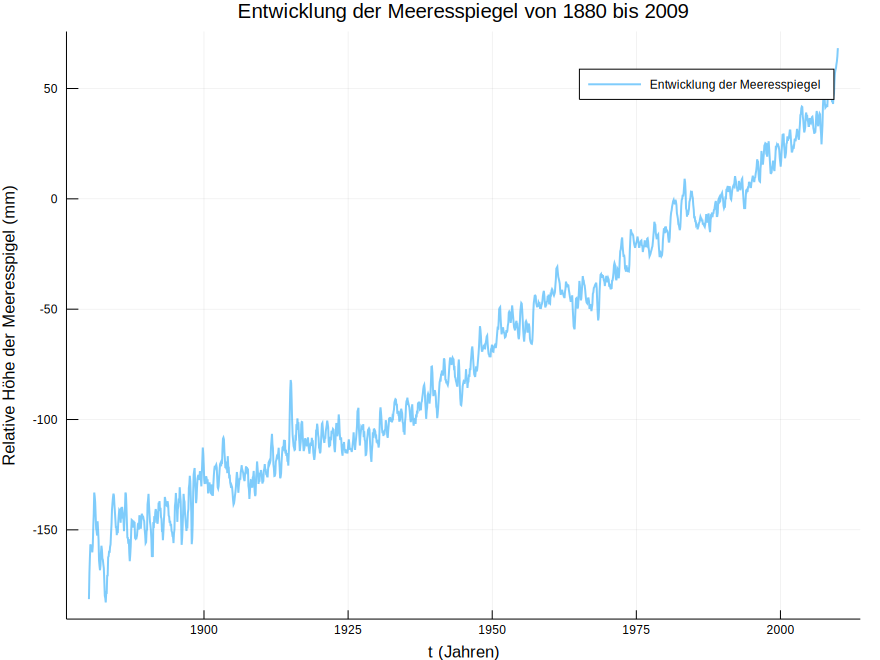

In [5]:
plot_gmsl = plot(data[:Time], data[:GMSL], 
    label = "Entwicklung der Meeresspiegel", 
    xlabel = "t (Jahren)", 
    ylabel = "Relative Höhe der Meeresspigel (mm)",
    title = "Entwicklung der Meeresspiegel von 1880 bis 2009",
)
png("gmsl.png")
plot_gmsl

In [6]:
linearmodel = fit(LinearModel, @formula(GMSL ~ Time), data)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: GMSL ~ 1 + Time

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)  -3060.07   12.8641 -237.877   <1e-99
Time          1.53785 0.0066127  232.561   <1e-99


In [7]:
@show coef(linearmodel)
@show stderror(linearmodel)
error = stderror(linearmodel)[1];

coef(linearmodel) = [-3060.07, 1.53785]
stderror(linearmodel) = [12.8641, 0.0066127]


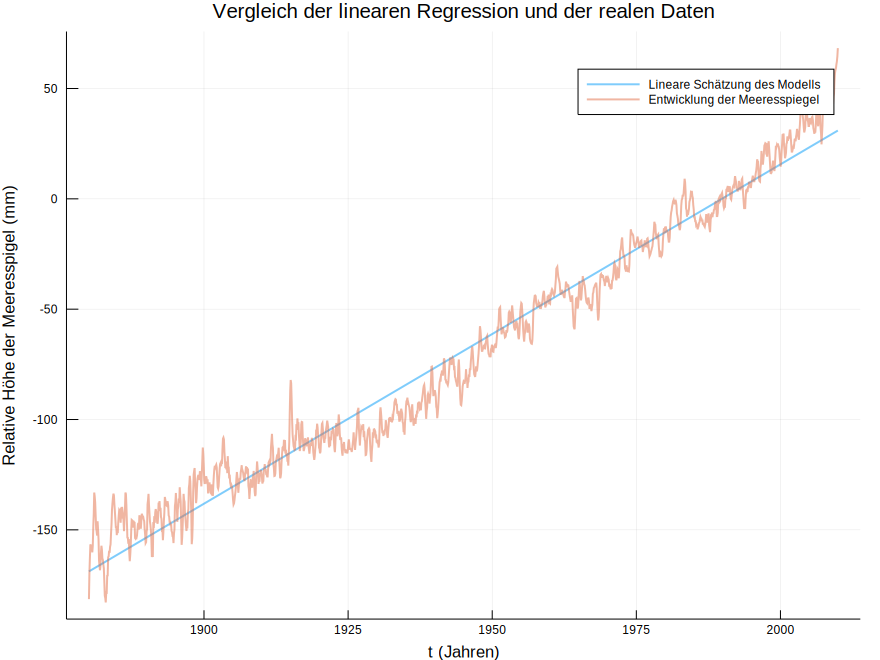

In [8]:
f(x) = coef(linearmodel)[2] * x + coef(linearmodel)[1]
plot_linear_regression = plot(xlabel = "t (Jahren)", ylabel = "Relative Höhe der Meeresspigel (mm)", title = "Vergleich der linearen Regression und der realen Daten")
plot!(data[:Time], f.(data[:Time]), label = "Lineare Schätzung des Modells")
plot!(data[:Time], data[:GMSL], label = "Entwicklung der Meeresspiegel")
png("linear_regression.png")
plot_linear_regression

In [9]:
include("../KalmanFilter.jl")
import .KalmanFilter

In [10]:
function shift(r)
   range(first(r) + 1, min(last(r) + 1, size(data)[1]))
end

shift (generic function with 1 method)

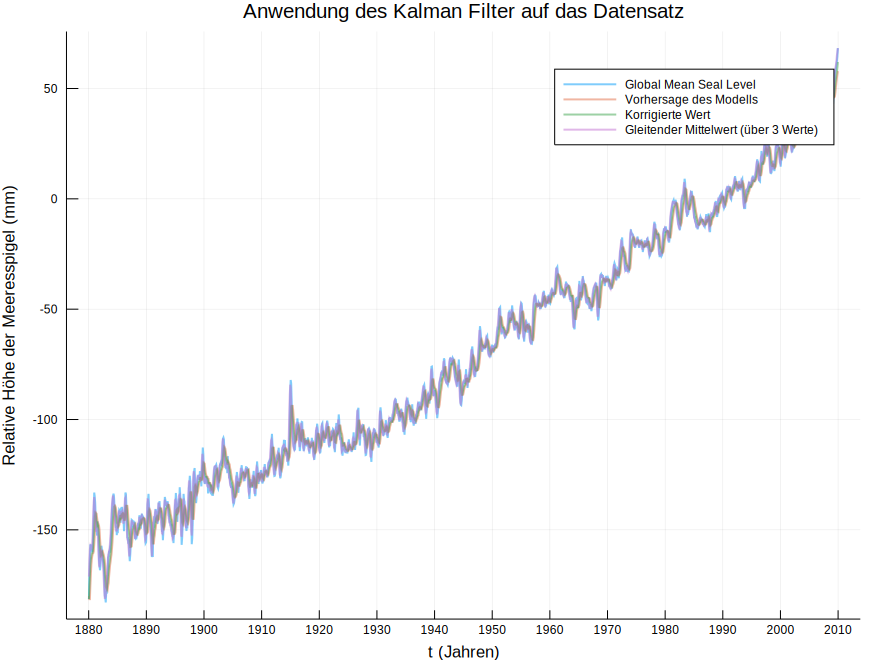

In [11]:
A = 1 # Zustandsübergangsmatrix
Q = 0.01

G = 1 # Messabbildung Matrix
R = 0.1

x̂_0 = data[1, :GMSL]
# x̂_0 = f(1)
Σ_0 = 1000

model = KalmanFilter.Kalman(A, Q, G, R, x̂_0, Σ_0)

data[:Fusioned] = map(x -> 0.0, data[:Time])
data[:Predicted] = map(x -> 0.0, data[:Time])
data[:Gain] = map(x -> 0.0, data[:Time])
data[:Moving_Avg] = map(x -> 0.0, data[:Time])

prev_prediction = -180

current_window = 1:3
for row in eachrow(data)
    y_cur = row[:GMSL]
    newInstance = KalmanFilter.next(model, y_cur)
    row[:Fusioned] = newInstance.fusioned
    row[:Predicted] = prev_prediction
    row[:Gain] = newInstance.gain
    row[:Moving_Avg] = mean(data[current_window, :GMSL])
    
    current_window = shift(current_window)
    prev_prediction = newInstance.predicted
    model = newInstance.model
end
plot_kalman = plot(
    xticks=(1800:10:2100), 
    xlabel = "t (Jahren)", 
    ylabel = "Relative Höhe der Meeresspigel (mm)",
    title = "Anwendung des Kalman Filter auf das Datensatz")
plot!(data[:Time], data[:GMSL], label = "Global Mean Seal Level")
plot!(data[:Time], data[:Predicted], label = "Vorhersage des Modells")
plot!(data[:Time], data[:Fusioned], label = "Korrigierte Wert")
plot!(data[:Time], data[:Moving_Avg], label = "Gleitender Mittelwert (über 3 Werte)")
png("gmsl-kalman.png")
plot_kalman

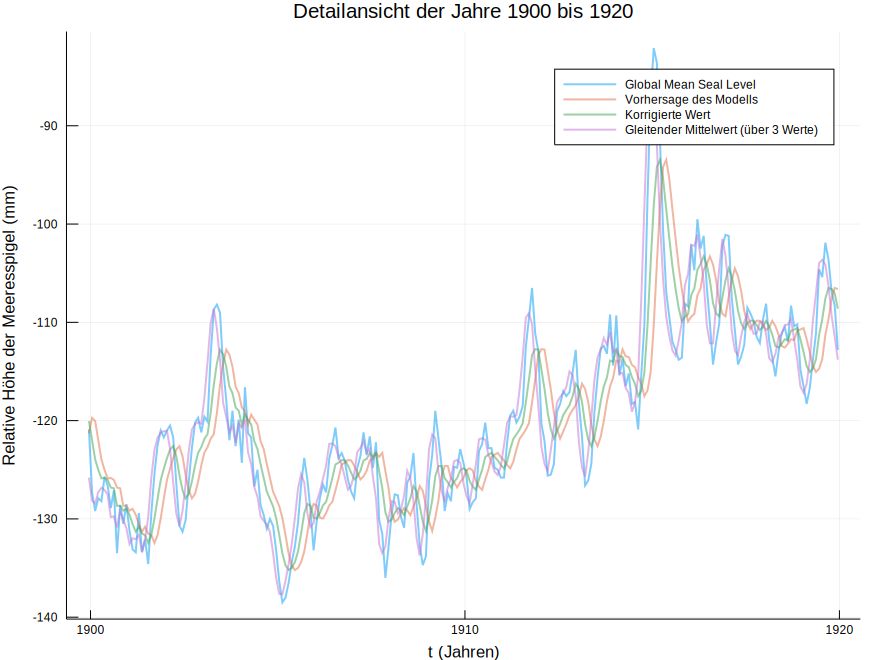

In [12]:
plot_1910 = plot(xticks=(1800:10:2100), 
    xlabel = "t (Jahren)", 
    ylabel = "Relative Höhe der Meeresspigel (mm)", 
    title = "Detailansicht der Jahre 1900 bis 1920")
plot!(data[240:480, :Time], data[240:480, :GMSL], label = "Global Mean Seal Level")
plot!(data[240:480, :Time], data[240:480, :Predicted], label = "Vorhersage des Modells")
plot!(data[240:480, :Time], data[240:480, :Fusioned], label = "Korrigierte Wert")
plot!(data[240:480, :Time], data[240:480, :Moving_Avg], label = "Gleitender Mittelwert (über 3 Werte)")
png("detailansicht-1900-1920-kalman.png")
plot_1910

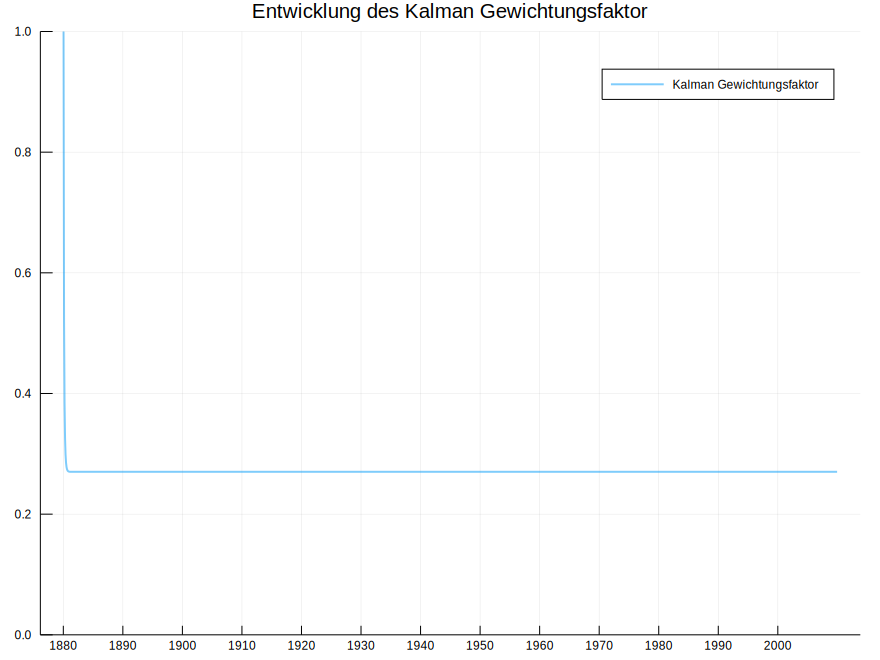

In [13]:
plot_kalman_gain = plot(data[:Time], data[:Gain], 
    label = "Kalman Gewichtungsfaktor", 
    ylim = (0, 1), 
    linewidth = 2, 
    title = "Entwicklung des Kalman Gewichtungsfaktor",
    xticks = 1800:10:2000)
png("kalman-gain.png")
plot_kalman_gain

### Untersuchung der Mehrdimensionale Daten

In [14]:
tables = []
timestamps = Set()
for file = readdir("sensor_readings")
    table = CSV.File("./sensor_readings/$file", header = 0, delim = ';') |> DataFrame
    rename!(table, Dict(:Column1 => :Time, :Column2 => :SeaLevel))
    deletecols!(table, 3:4)
    table[:SeaLevel] = map(x -> x - 7007, table[:SeaLevel])
    table[:SeaLevel] = map(x -> (abs(x) > 5000) ? missing : x, table[:SeaLevel])
    push!(tables, table)
end
result = by(vcat(tables...), :Time) do d
    sum(skipmissing(d[:SeaLevel])) / length(collect(skipmissing(d[:SeaLevel])))
end


,Time,x1
,Float64⍰,Float64
1,1807.04,-102.0
2,1807.13,-76.0
3,1807.21,-111.0
4,1807.29,-54.0
5,1807.38,36.0
6,1807.46,-55.0
7,1807.54,-11.0
8,1807.63,44.0
9,1807.71,-6.0


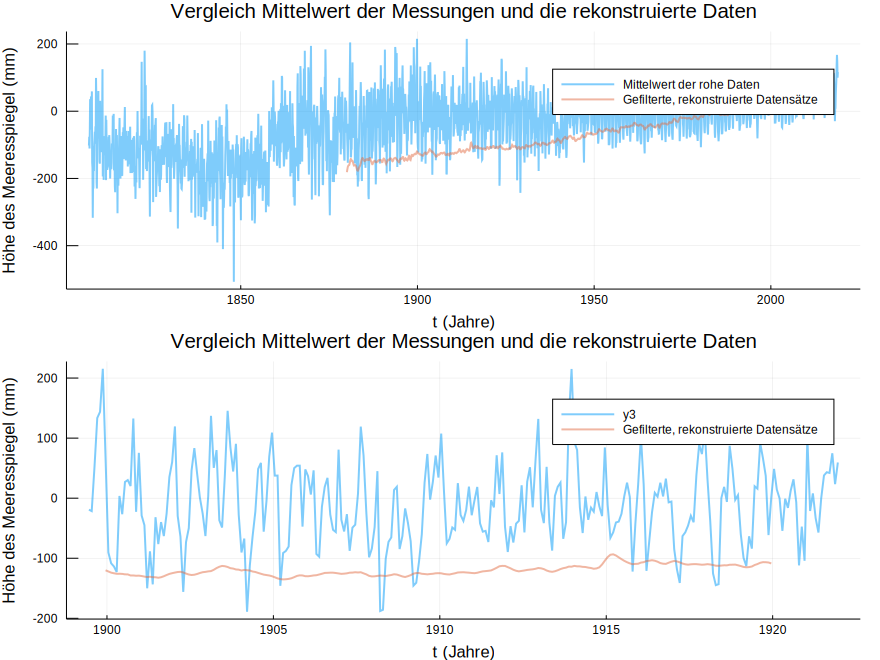

In [15]:
plot(title = "Vergleich Mittelwert der Messungen und die rekonstruierte Daten",
    ylabel = "Höhe des Meeresspiegel (mm)", xlabel = "t (Jahre)",
    layout = @layout [a; b])
plot!(result[:Time], result[:x1], label = "Mittelwert der rohe Daten", subplot = 1)
plot!(data[:Time], data[:Fusioned], label = "Gefilterte, rekonstruierte Datensätze", subplot = 1)

plot!(result[1110:1380, :Time], result[1110:1380, :x1], subplot = 2)
plot!(data[240:480, :Time], data[240:480, :Fusioned], label = "Gefilterte, rekonstruierte Datensätze", subplot = 2)

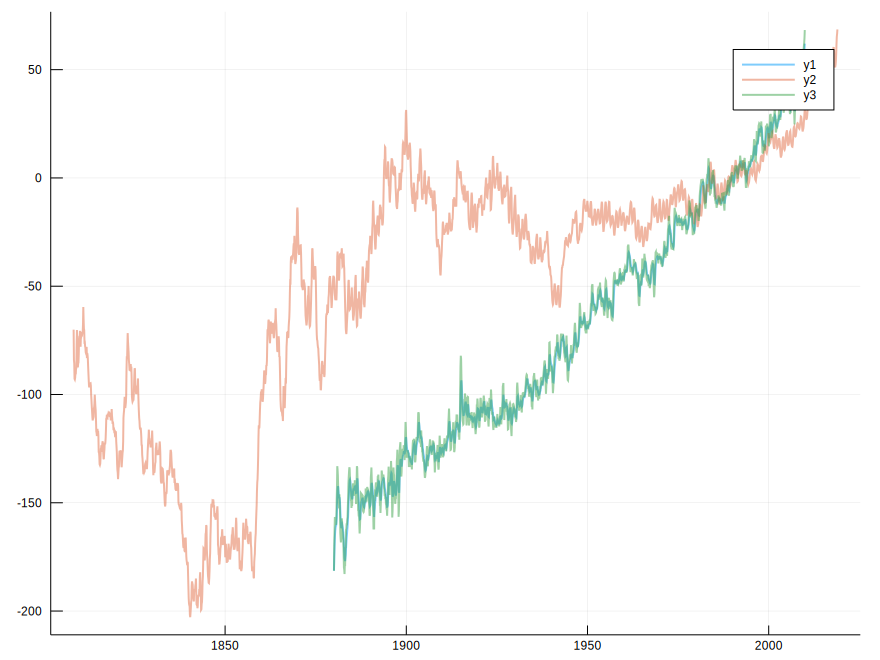

In [16]:
A = 1 # Zustandsübergangsmatrix
G = 1 # Messabbildung Matrix
Q = .01
R = 6

x̂_0 = result[1, :x1]
# x̂_0 = f(1)
Σ_0 = -1.6

model = KalmanFilter.Kalman(A, Q, G, R, x̂_0, Σ_0)
model_2 = KalmanFilter.Kalman(A, Q, G, R, x̂_0, Σ_0)

result[:Fusioned] = map(x -> 0.0, result[:Time])
result[:Predicted] = map(x -> 0.0, result[:Time])

prev_prediction = x̂_0
for row in eachrow(result)
    y_cur = row[:x1]
    row[:Fusioned] = KalmanFilter.fusion(model, y_cur).state
    row[:Predicted] = prev_prediction
    prev_prediction = KalmanFilter.predict(model).state
end
plot()
#plot(result[:Time], result[:x1])
plot!(data[:Time], data[:Fusioned])
plot!(result[15:end, :Time], result[15:end, :Fusioned])
plot!(data[:Time], data[:GMSL])